In [2]:
import sys
sys.path.append('src')
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [3]:
# Load into Dask
import dask.dataframe as dd
import numpy as np
import glob

channel_order = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
            ]
sfreq = 200
eeg_ids = metadata['eeg_id'].to_list()

ddf_list = []
for eeg_id in eeg_ids:
  f_name = f'data/eeg/{eeg_id}.parquet'
  temp_ddf = dd.read_parquet(f_name).drop('EKG', axis=1)[channel_order]
  temp_ddf['eeg_id'] = str(eeg_id)
  temp_ddf = temp_ddf.set_index('eeg_id')
  ddf_list.append(temp_ddf)

ddf = dd.concat(ddf_list)
ddf


,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
npartitions=1000,,,,,,,,,,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [13]:
sig1 = ddf.loc['2509824693'].compute()
sig1

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
eeg_id,,,,,,,,,,,,,,,,,,,
2509824693,91.980003,54.500000,70.980003,69.650002,57.950001,35.360001,-29.510000,79.750000,52.639999,35.889999,18.080000,-30.309999,35.360001,25.250000,30.570000,14.620000,-17.549999,22.330000,2.13
2509824693,86.129997,48.650002,57.950001,56.360001,49.980000,24.459999,-40.939999,81.080002,51.040001,28.180000,9.300000,-36.150002,-17.549999,26.320000,25.250000,9.570000,-20.740000,13.560000,-4.25
2509824693,76.300003,46.520000,52.099998,47.320000,39.340000,16.480000,-50.509998,40.410000,38.549999,19.410000,3.720000,-31.629999,29.240000,27.910000,21.799999,6.110000,-31.900000,16.219999,-5.58
2509824693,82.940002,52.900002,72.309998,51.310001,42.270000,22.860001,-42.000000,64.070000,1.860000,12.760000,-3.990000,-32.700001,31.370001,15.950000,19.139999,3.460000,-19.139999,14.090000,-6.38
2509824693,93.839996,65.660004,74.970001,56.889999,56.360001,41.470001,-14.620000,56.619999,45.459999,30.040001,19.410000,-30.570000,35.619999,32.700001,34.290001,19.139999,-10.630000,23.930000,3.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509824693,51.310001,40.410000,40.669998,38.810001,49.709999,51.310001,23.129999,14.890000,25.250000,46.790001,36.419998,43.860001,13.290000,9.040000,25.790001,14.890000,5.320000,2.390000,7.98
2509824693,42.000000,33.759998,27.910000,26.580000,39.610001,43.070000,11.430000,3.460000,11.700000,34.290001,26.580000,30.040001,1.060000,-2.390000,10.630000,2.390000,-13.290000,-10.100000,-2.66
2509824693,35.619999,21.530001,27.650000,24.990000,35.360001,33.230000,3.190000,3.720000,13.290000,31.100000,19.410000,24.459999,1.060000,-0.800000,8.770000,-3.460000,-12.760000,-7.710000,-8.24


In [14]:
## MNE setup
import mne

mne_info = mne.create_info(ch_names=sig1.columns.tolist(), sfreq=200, ch_types='eeg')
mne_info.set_montage('standard_1020')
    
sig1_data = np.array(sig1.transpose())
sig1_data = np.nan_to_num(sig1_data)
    
raw = mne.io.RawArray(sig1_data, mne_info)
raw.apply_function(lambda x: x / 20e6, picks='eeg')

Creating RawArray with float64 data, n_channels=19, n_times=53600
    Range : 0 ... 53599 =      0.000 ...   267.995 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


Creating RawArray with float64 data, n_channels=19, n_times=53600
    Range : 0 ... 53599 =      0.000 ...   267.995 secs
Ready.


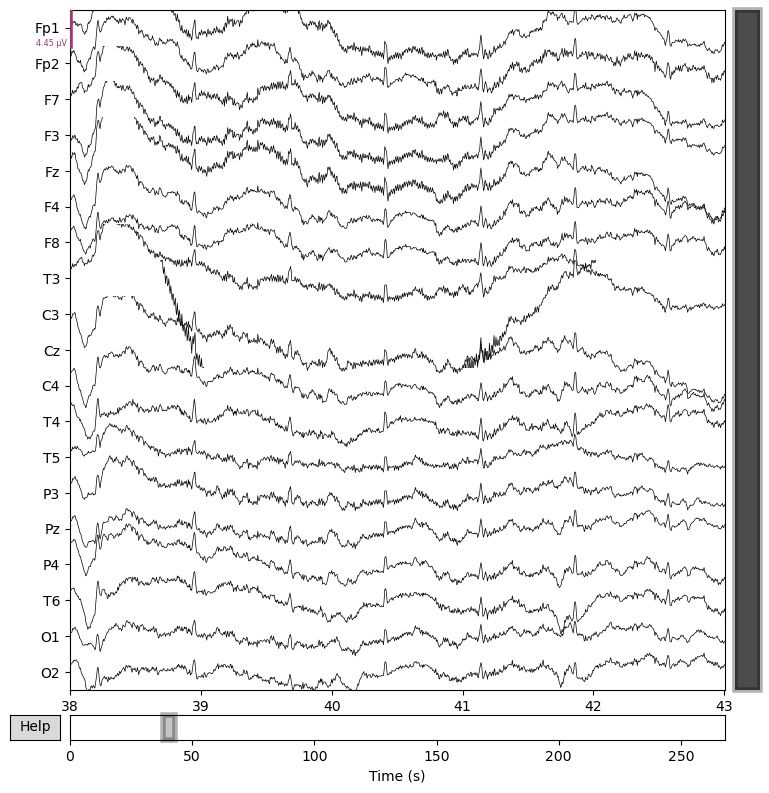

In [19]:
from visualize import VisualizeEEG

vis = VisualizeEEG(sig1)
vis.plot_signal(38, 5)


vis.plot_topomap(38, 45, 1)


